# 21cm Line Emission Simulations, with Different Backends

## This notebook demonstrates how to run a 21cm line emission simulation, to obtain visibilities and dirty images, and create a mosaic of pointings.

## For more details, see main code on `line_emission.py`

In [1]:
!export HDF5_USE_FILE_LOCKING='FALSE'

In [38]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from typing import List
from ska_sdp_datamodels.image.image_model import Image as RASCILImage
import matplotlib.pyplot as plt


from karabo.data.external_data import HISourcesSmallCatalogDownloadObject
from karabo.imaging.image import Image, ImageMosaicker
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.util import auto_choose_dirty_imager_from_sim
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from karabo.simulation.line_emission import CircleSkyRegion, line_emission_pipeline, generate_gaussian_beam_data, gaussian_beam_fwhm_for_frequency
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler

In [3]:
# Image details
npixels = 4096
image_width_degrees = 2
cellsize_radians = np.radians(image_width_degrees) / npixels

# The number of time steps is then determined as total_length / integration_time.
observation_length = timedelta(seconds=10000)  # 14400 = 4hours
integration_time = timedelta(seconds=10000)

output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp for Example line emission simulation


In [4]:
# Define observation pointings
pointings = [
    CircleSkyRegion(
        radius=2 * u.deg, center=SkyCoord(ra=20, dec=-30, unit="deg", frame="icrs")
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=20, dec=-31.4, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-30, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-31.4, unit="deg", frame="icrs"),
    ),
]

In [5]:
# Primary beam settings
should_apply_primary_beam = False

# Create interferometer simulation
if should_apply_primary_beam:
    beam_type = "Gaussian beam"
    # Options: "Aperture array", "Isotropic beam", "Gaussian beam", "VLA (PBCOR)"
    gaussian_fwhm = 50  # Degrees
    gaussian_ref_freq = 8e8  # Hz
else:
    beam_type = "Isotropic beam"
    gaussian_fwhm = 0
    gaussian_ref_freq = 0

In [6]:
# Load catalog of sources
catalog_path = HISourcesSmallCatalogDownloadObject().get()
print(catalog_path)
sky = SkyModel.get_sky_model_from_h5_to_xarray(
    path=catalog_path,
)

/users/lmachado/.cache/karabo-LTM-lmachado-LfgGUMdc5M/objects-download-IzWvEC4tro/surveys/hi-small/HI_sources_small_catalog_v0.h5


In [7]:
# Define observation channels and duration
observation = Observation(
    start_date_and_time=datetime(2000, 3, 20, 12, 6, 39),
    length=observation_length,
    number_of_time_steps=int(
        observation_length.total_seconds() / integration_time.total_seconds()
    ),
    start_frequency_hz=7e8,
    frequency_increment_hz=8e7,
    number_of_channels=2,
)

In [8]:
# Instantiate interferometer
# Leave time_average_sec as 10, since OSKAR examples use 10.
# Not sure of the meaning of this parameter.
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type=beam_type,
    gauss_beam_fwhm_deg=gaussian_fwhm,
    gauss_ref_freq_hz=gaussian_ref_freq,
    use_dask=False,
)

In [28]:
dirty_imager = auto_choose_dirty_imager_from_sim(
    simulator_backend,
    DirtyImagerConfig(
        imaging_npixel=npixels,
        imaging_cellsize=cellsize_radians,
    ),
)

## Simulation: compute visibilities and dirty images (first, without primary beam effects)

In [11]:
%%time
# Run pipeline for each of the available backends
backend_to_dirty_images = {}

for simulator_backend, telescope_name in (
    (SimulatorBackend.OSKAR, "SKA1MID"),
    (SimulatorBackend.RASCIL, "MID"),
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    visibilities, dirty_images = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager=dirty_imager,
        primary_beams=None,
        should_perform_primary_beam_correction=False,
    )

    backend_to_dirty_images[simulator_backend] = dirty_images

print("Done with line emission pipelines")

Selected backend: SimulatorBackend.OSKAR
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/interferometer-S3ozDduJYO for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p0
Processing pointing 1...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p1
Processing pointing 2...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p2
Processing pointing 3...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p3
Processing frequency channel 1...
Processing pointing 0...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f1_p0
Processing pointing 1...
Saved v

/users/lmachado/Karabo-Pipeline/karabo/imaging/image.py:118: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


Processing pointing 1...
W|                                                                   
W|== WARNING: Skipped 3227 visibility points.
W|                                                                   
Processing pointing 2...
W|                                                                   
W|== WARNING: Skipped 3227 visibility points.
W|                                                                   
Processing pointing 3...
W|                                                                   
W|== WARNING: Skipped 3226 visibility points.
W|                                                                   
Processing frequency channel 1...
Processing pointing 0...
W|                                                                   
W|== WARNING: Skipped 3564 visibility points.
W|                                                                   
Processing pointing 1...
W|                                                                   
W|== WARNING: Skipped 3572 

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Done with line emission pipelines
CPU times: user 1min 14s, sys: 11.9 s, total: 1min 26s
Wall time: 1min 32s


In [12]:
%%time
# Create mosaics of pointings for each frequency channel
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for {simulator_backend = }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)

Computing mosaic for simulator_backend = <SimulatorBackend.OSKAR: 'OSKAR'>
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-M0oofzWALA for restored fits-path
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-PxNF3PztZc for restored fits-path
Computing mosaic for simulator_backend = <SimulatorBackend.RASCIL: 'RASCIL'>
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-2IsqJgcgDz for restored fits-path
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-14MLqktulp for restored fits-path
CPU times: user 4min 14s, sys: 52.3 s, total: 5min 6s
Wall time: 5min 6s


In [13]:
# Add all mosaics across frequency channels to create one final mosaic image
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-aGGuML0w3k for restored fits-path
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-siSa0oOWun for restored fits-path


## Visualization of dirty images and mosaics

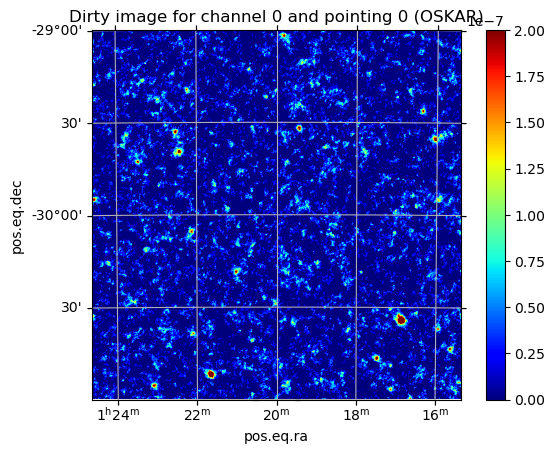

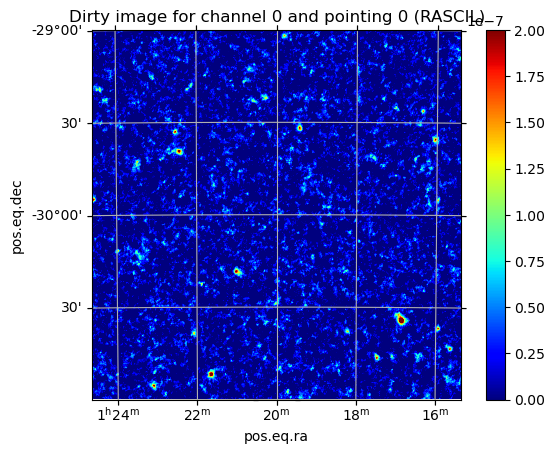

In [51]:
%matplotlib inline
backend_to_dirty_images[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty image for channel 0 and pointing 0 (OSKAR)",
)

backend_to_dirty_images[SimulatorBackend.RASCIL][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty image for channel 0 and pointing 0 (RASCIL)",
)

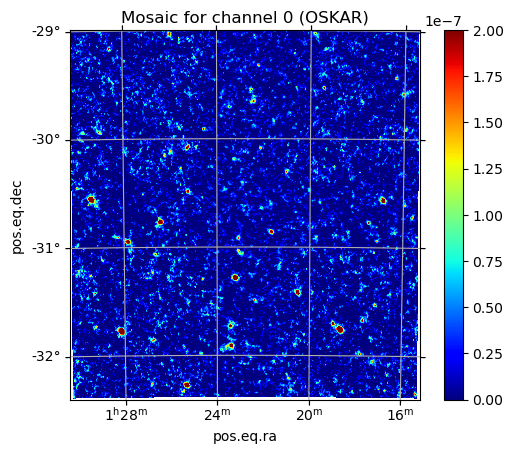

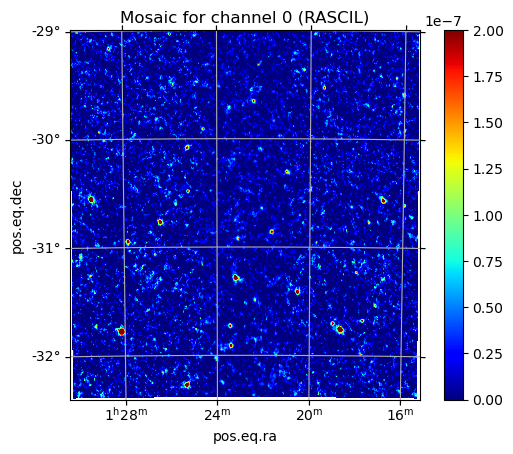

In [52]:
%matplotlib inline
backend_to_mosaics[SimulatorBackend.OSKAR][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Mosaic for channel 0 (OSKAR)",
)
backend_to_mosaics[SimulatorBackend.RASCIL][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Mosaic for channel 0 (RASCIL)",
)

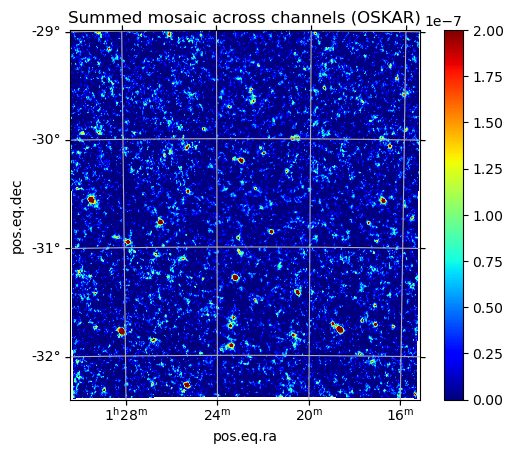

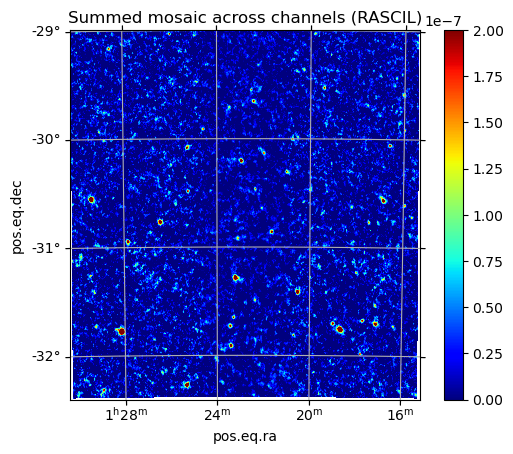

In [53]:
%matplotlib inline
backend_to_summed_mosaics[SimulatorBackend.OSKAR].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Summed mosaic across channels (OSKAR)",
)
backend_to_summed_mosaics[SimulatorBackend.RASCIL].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Summed mosaic across channels (RASCIL)",
)

## Comparison of mosaics for different backends

Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-ZII4W6k5zT for restored fits-path


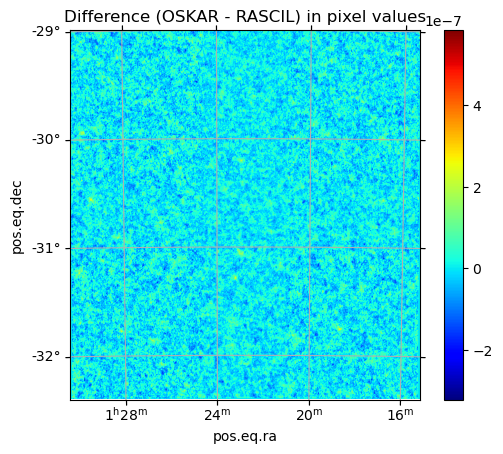

In [17]:
%matplotlib inline

# Compute difference in pixel values between mosaics from different backends
difference_in_data = (
    backend_to_summed_mosaics[SimulatorBackend.OSKAR].data
    - backend_to_summed_mosaics[SimulatorBackend.RASCIL].data
)
difference_header = backend_to_summed_mosaics[SimulatorBackend.OSKAR].header

difference_image = Image(
    data=np.nan_to_num(difference_in_data),  # To convert NaN into 0 at borders of image
    header=difference_header,
)

difference_image.plot(
    block=True,
    title="Difference (OSKAR - RASCIL) in pixel values",
)

# Primary Beam Effects

## We instantiate different interferometers (with / without primary beam effects), and provide primary beams (Gaussian, in this example) to the `line_emission_pipeline`

## NOTE!

- OSKAR only support Gaussian beams, and ignores the `primary_beams` array, using only the `gaussian_*` parameters in `InterferometerSimulation`.

- RASCIL ignores the `gaussian_*` parameters in `InterferometerSimulation`, and instead uses the `primary_beams` array provided into `line_emission_pipeline`

In [19]:
# Instantiate interferometers
interferometer_without_primary_beam = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Isotropic beam",
    gauss_beam_fwhm_deg=0,
    gauss_ref_freq_hz=0,
    use_dask=False,
)

interferometer_with_primary_beam = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Gaussian beam",
    gauss_beam_fwhm_deg=gaussian_fwhm,
    gauss_ref_freq_hz=gaussian_ref_freq,
    use_dask=False,
)

## Generate data for primary beams (2D np.array for each frequency channel) -> here, we use Gaussian beams

In [29]:
primary_beams: List[RASCILImage] = []

# Compute frequency channels
frequency_channel_starts = np.linspace(
    observation.start_frequency_hz,
    observation.start_frequency_hz
    + observation.frequency_increment_hz * observation.number_of_channels,
    num=observation.number_of_channels,
    endpoint=False,
)

# RASCIL supports custom primary beams
# Here we create a sample beam (Gaussian)
# as a 2D np.array of shape (npixels, npixels)
for frequency in frequency_channel_starts:
    fwhm_degrees = gaussian_beam_fwhm_for_frequency(frequency)
    fwhm_pixels = (
        fwhm_degrees / np.degrees(dirty_imager.config.imaging_cellsize)
    )

    primary_beam = generate_gaussian_beam_data(
        fwhm_pixels=fwhm_pixels,
        x_size=dirty_imager.config.imaging_npixel,
        y_size=dirty_imager.config.imaging_npixel,
    )
    primary_beams.append(primary_beam)

## We then run the simulations with and without primary beams, and compare the resulting dirty images

## NOTE! For the primary beams, we also perform a primary beam correction

In [30]:
backend_to_dirty_images_without_primary_beams = {}
backend_to_dirty_images_corrected_for_primary_beams = {}

for simulator_backend, telescope_name in (
    (SimulatorBackend.OSKAR, "SKA1MID"),
    (SimulatorBackend.RASCIL, "MID"),
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    visibilities_without_primary_beam, dirty_images_without_primary_beam = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer_without_primary_beam,
        simulator_backend=simulator_backend,
        dirty_imager=dirty_imager,
        primary_beams=None,
        should_perform_primary_beam_correction=False,
    )

    backend_to_dirty_images_without_primary_beams[simulator_backend] = dirty_images_without_primary_beam
    
    visibilities_corrected_for_primary_beam, dirty_images_corrected_for_primary_beam = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer_without_primary_beam,
        simulator_backend=simulator_backend,
        dirty_imager=dirty_imager,
        primary_beams=primary_beams,
        should_perform_primary_beam_correction=True,
    )

    backend_to_dirty_images_corrected_for_primary_beams[simulator_backend] = dirty_images_corrected_for_primary_beam
    

Selected backend: SimulatorBackend.OSKAR
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/interferometer-3j1j1smHDC for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p0
Processing pointing 1...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p1
Processing pointing 2...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p2
Processing pointing 3...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p3
Processing frequency channel 1...
Processing pointing 0...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f1_p0
Processing pointing 1...
Saved v

/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p0
Processing pointing 1...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p1
Processing pointing 2...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p2
Processing pointing 3...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f0_p3
Processing frequency channel 1...
Processing pointing 0...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f1_p0
Processing pointing 1...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f1_p1
Processing pointing 2...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f1_p2
Processing pointing 3...


/users/lmachado/Karabo-Pipeline/karabo/simulation/interferometer.py:408: UserWarning: 
                    Providing a custom primary beam is not supported by OSKAR.
                    The provided primary beam will be ignored.
                    To configure a primary beam effect with OSKAR,
                    set the InterferometerSimulation primary beam parameters
                    (FWHM and reference frequency) instead.
                    
  warn(


Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp/visibilities_f1_p3
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...


Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-lHi88zF2zp directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing poi

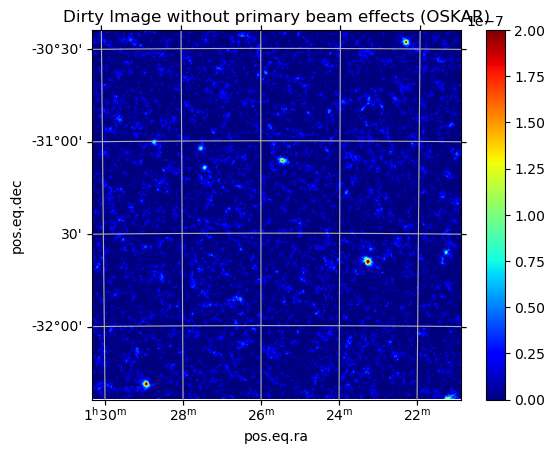

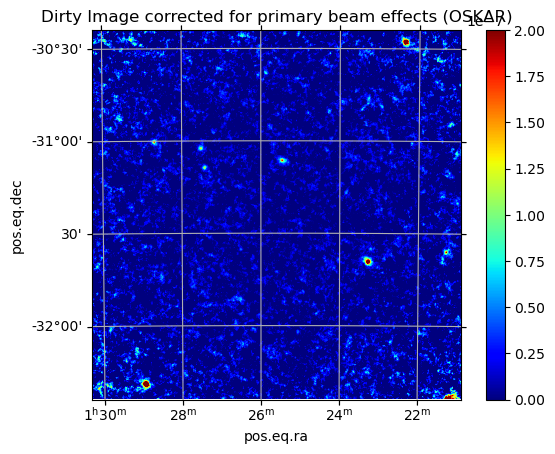

In [36]:
%matplotlib inline
backend_to_dirty_images_without_primary_beams[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty Image without primary beam effects (OSKAR)",
)

backend_to_dirty_images_corrected_for_primary_beams[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty Image corrected for primary beam effects (OSKAR)",
)

## Fractional difference between image without beam and image corrected for primary beam -> ideally, there should be no differences

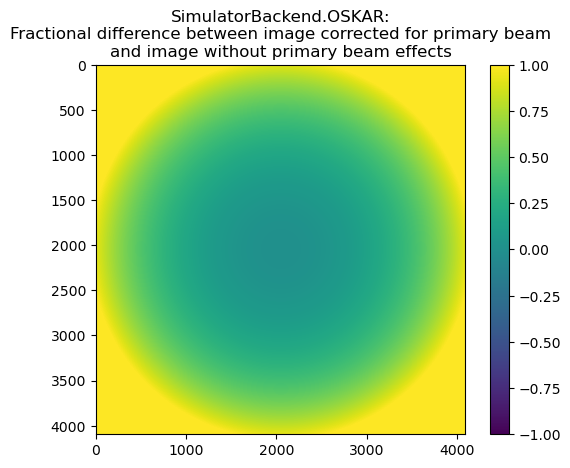

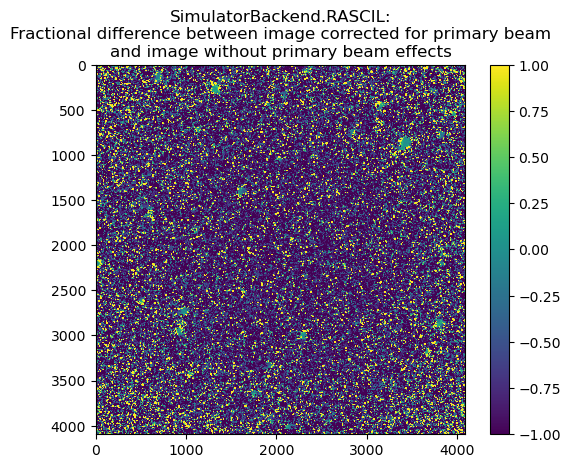

<Figure size 640x480 with 0 Axes>

In [50]:
%matplotlib inline

for simulator_backend in (SimulatorBackend.OSKAR, SimulatorBackend.RASCIL):
    fractional_difference = backend_to_dirty_images_corrected_for_primary_beams[simulator_backend][0][0].data / backend_to_dirty_images_without_primary_beams[simulator_backend][0][0].data - 1

    plt.imshow(
        fractional_difference[0][0],
        vmin=-1,
        vmax=1,
    )
    plt.title(
        f"{simulator_backend}:\nFractional difference between image corrected for primary beam\nand image without primary beam effects",
    )
    plt.colorbar()
    plt.show()
    plt.clf()